# Exploring and Modeling Passing

This Jupyter Notebook will not only explore the passing data available in the StatsBomb data, but also present a general pipeline to model the outcomes of passes.

Let's start by calling in our libraries and data. We wrap the library calls with `suppressMessages()` to reduce the amount of warning messages we receive. If you are new to the StatsBomb data, we cover it in the `01_basic_match_event_data` notebook.

In [3]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(rms))
suppressMessages(library(StatsBombR))

event_data <- StatsBombFreeEvents()

Warning message:
“replacing previous import ‘foreach::accumulate’ by ‘purrr::accumulate’ when loading ‘StatsBombR’”Warning message:
“replacing previous import ‘jsonlite::flatten’ by ‘purrr::flatten’ when loading ‘StatsBombR’”Warning message:
“replacing previous import ‘foreach::when’ by ‘purrr::when’ when loading ‘StatsBombR’”

[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."
[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."
[1] "Whilst we are keen to share data and facilitate research, we also urge you to be responsible with the data. Please register your details on https://www.statsbomb.com/resource-centre and read our User Agreement carefully."


We first need to create a clean data frame that we can easily manipulate. We grab all of the pass events where the pass outcome is either `NA`, `Incomplete`, `Out` or `Pass Offside`. The latter three types indicate _failed_ passes. We also clean up the `under_pressure` and `location` columns. Additionally, the data contains detailed position data. We comebine some positions together, such as fullbacks and wingbacks. We are left with a clean data frame called `passes_clean`, which provide the head for below.

In [16]:
passes_unclean <- event_data %>% filter(type.name == "Pass") %>% filter(pass.outcome.name %in% c(NA, "Incomplete", "Out", "Pass Offside"))
passes_unclean$under_pressure <- ifelse(is.na(passes_unclean$under_pressure), FALSE, TRUE)

passes_unclean$start_x <- NA
passes_unclean$start_y <- NA
passes_unclean$end_x <- NA
passes_unclean$end_y <- NA

for(r in 1:nrow(passes_unclean)) {
    start_loc <- unlist(passes_unclean$location[r])
    passes_unclean$start_x[r] <- start_loc[1]
    passes_unclean$start_y[r] <- start_loc[2]
    end_loc <- unlist(passes_unclean$pass.end_location[r])
    passes_unclean$end_x[r] <- end_loc[1]
    passes_unclean$end_y[r] <- end_loc[2]
}

passes_unclean <- passes_unclean %>% filter(is.na(pass.type.name))
passes_unclean$pass.outcome <- ifelse(passes_unclean$pass.outcome.name %in% c("Incomplete", "Out", "Pass Offside"), 0, 1)
passes_clean <- passes_unclean %>% select(player.id, player.name, position.name, start_x, start_y, duration, under_pressure, pass.length, pass.angle, pass.height.name, pass.body_part.name, end_x, end_y, pass.outcome)

positions <- passes_clean$position.name
mapping <- data.frame(position = unique(passes_clean$position.name),
                     abbrev = c('FW', 'W', 'CB', 'W', 'FB', 'CM', 'FW', 'CM', 'FW', 'CB', 'CM', 'W', 'CB', 'GK', 'FB', 'W', 'FW', 'CDM', 'CDM', 'CAM', 'CDM', 'CAM', 'CAM', 'FB', 'FB'))
passes_clean$position.name <- factor(positions,levels = mapping$position,labels = mapping$abbrev)

head(passes_clean)

Next, we want to model the probability that a pass is completed. It is important to note we are only modeling one side of the relationship. A pass involves two players: the one kicking the ball and the one receiving the ball. For the purposes of this notebook, we only use information from the player kicking the ball.

Off the top of the head, the most basic things that would decide the accuracy of a pass may be the distance of the pass and how long it took to reach its target. It makes sense that longer passes or ones that take a long time to reach their target may fail more often as the defense has time to adjust. We explore this thought below.

In [20]:
simple_pass_model <- glm(pass.outcome ~ duration + pass.length, data = passes_clean, family = binomial())
summary(simple_pass_model)


Call:
glm(formula = pass.outcome ~ duration + pass.length, family = binomial(), 
    data = passes_clean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9699  -1.1378   0.6961   0.7802   1.9339  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.806086   0.032681  55.264  < 2e-16 ***
duration    -0.175223   0.022856  -7.666 1.77e-14 ***
pass.length -0.022417   0.001685 -13.303  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 24963  on 21304  degrees of freedom
Residual deviance: 24017  on 21302  degrees of freedom
AIC: 24023

Number of Fisher Scoring iterations: 4


From the model output above, it is clear that indeed duration and pass length have a negative (note, non-causal, however) effect on the likelihood of a pass. This all makes sense. However, there may be several other effects. How about if a player is under a pressure? Or if she passes the ball in the air versus the ground. How about _where_ a pass initiates and ends? To explore these thoughts, we add `under_pressure`,  `pass.height.name` and location data to our model.

In [23]:
simple_pass_expanded_model <- glm(pass.outcome ~ duration + pass.length + under_pressure + pass.height.name + start_x + end_x + start_x:end_x, data = passes_clean, family = binomial())
summary(simple_pass_expanded_model)


Call:
glm(formula = pass.outcome ~ duration + pass.length + under_pressure + 
    pass.height.name + start_x + end_x + start_x:end_x, family = binomial(), 
    data = passes_clean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5541  -0.6741   0.3857   0.6375   2.2942  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                1.220e+00  1.044e-01  11.684  < 2e-16 ***
duration                  -1.684e-01  2.647e-02  -6.361 2.01e-10 ***
pass.length                6.251e-02  2.712e-03  23.050  < 2e-16 ***
under_pressureTRUE        -1.686e-01  4.417e-02  -3.818 0.000135 ***
pass.height.nameHigh Pass -1.867e+00  4.978e-02 -37.510  < 2e-16 ***
pass.height.nameLow Pass  -1.393e+00  5.805e-02 -23.996  < 2e-16 ***
start_x                    9.175e-02  3.020e-03  30.384  < 2e-16 ***
end_x                     -5.708e-02  2.241e-03 -25.466  < 2e-16 ***
start_x:end_x             -4.164e-04  2.491e-05 -16.716  < 2e-16 ***

We see that when the `under_pressure` flag is set to `TRUE`, we, on average, see a decrease in the probability that a pass succeeds. This makes sense, a player facing pressure may be more likely to make a mistake. We also see that passes in the air have less accuracy, and that accuracy decreases the higher the pass (see the difference between `High Pass` and `Low Pass`. Finally, we also see that starting and endling locations matter, where passes ending in the final third have a lower accuracy. Additionally, through the interaction term `start_x:end_x`, which is simply the starting x multiplied by the ending x, we see that there is a strong negative relationship, meaning passes starting and ending closer to the opponent's goal have a higher rate of failure.

In [18]:
base_model <- glm(pass.outcome ~ duration + pass.length + under_pressure + duration:pass.length + start_x + end_x + start_x:end_x + pass.height.name, data = passes_clean, family=binomial())
positional_model <- glm(pass.outcome ~ duration + pass.length + under_pressure + duration:pass.length + start_x + end_x + start_x:end_x + pass.height.name + pass.body_part.name + position.name + position.name:pass.height.name, data = passes_clean, family=binomial())

In [19]:
summary(positional_model)


Call:
glm(formula = pass.outcome ~ duration + pass.length + under_pressure + 
    duration:pass.length + start_x + end_x + start_x:end_x + 
    pass.height.name + pass.body_part.name + position.name + 
    position.name:pass.height.name, family = binomial(), data = passes_clean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5187  -0.5776   0.3471   0.6367   3.3231  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                -1.178e+00  2.852e-01  -4.129
duration                                    3.014e-01  4.365e-02   6.905
pass.length                                 8.305e-02  3.746e-03  22.168
under_pressureTRUE                         -8.188e-02  4.520e-02  -1.812
start_x                                     1.121e-01  3.355e-03  33.409
end_x                                      -4.801e-02  2.368e-03 -20.274
pass.height.nameHigh Pass                  -1.469e+00  1.455e-01 -10.097
pass.h

In [ ]:
model <- glm(pass.outcome ~ duration + pass.length + under_pressure + duration:pass.length + start_x + end_x + start_x:end_x + pass.height.name + position.name + position.name:pass.height.name + position.name:pass.length + pass.body_part.name, data = passes_clean, family=binomial())

summary(model)

passes_clean$pred <- predict(model, passes_clean, type = "response")

passes_clean <- passes_clean %>% na.omit()

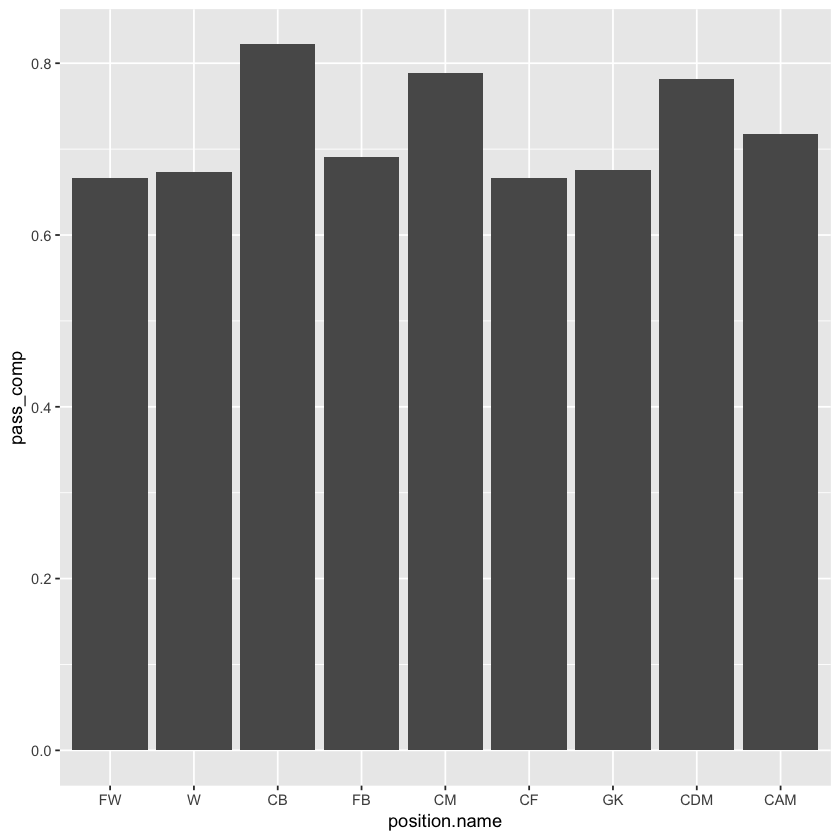

In [9]:
passes_clean %>% 
group_by(position.name) %>% 
summarise(pass_comp = mean(pass.outcome)) %>% 
ggplot(aes(x = position.name, y = pass_comp)) +
    geom_bar(stat = "identity")

In [10]:
player_passing <- passes_clean %>% group_by(player.name) %>% summarise(pass_comp = mean(pass.outcome), avg_pass_comp = mean(pred), passes = n()) %>% filter(passes > 100) %>% mutate(diff = pass_comp - avg_pass_comp) %>% arrange(-diff)
players <- player_passing$player.name
passes_clean <- passes_clean %>% filter(player.name %in% players)

In [11]:
pass_actual_boot <- passes_clean %>%
group_by(player.name) %>%
  do(data.frame(rbind(smean.cl.boot(.$pass.outcome,B=2000))))

pass_pred_boot <- passes_clean %>%
group_by(player.name) %>%
  do(data.frame(rbind(smean.cl.boot(.$pred,B=2000))))

In [12]:
names(pass_actual_boot) <- c("player", "mean_pass_comp", "mean_lower_pass_comp", "mean_upper_pass_comp")
names(pass_pred_boot) <- c("player", "mean_pred_pass_comp", "mean_lower_pred_pass_comp", "mean_upper_pred_pass_comp")
passing <- merge(pass_actual_boot, pass_pred_boot, by = c("player"))

In [13]:
passing$sig <- ifelse(passing$mean_pass_comp < passing$mean_lower_pred_pass_comp, 1,
                     ifelse(passing$mean_pass_comp > passing$mean_upper_pred_pass_comp, 1, 0))
passing$est_diff <- passing$mean_pass_comp - passing$mean_pred_pass_comp

In [14]:
passing %>% arrange(est_diff)

player,mean_pass_comp,mean_lower_pass_comp,mean_upper_pass_comp,mean_pred_pass_comp,mean_lower_pred_pass_comp,mean_upper_pred_pass_comp,sig,est_diff
Kealia Ohai,0.4867257,0.3893805,0.5752212,0.6620042,0.6161939,0.7045673,1,-0.17527854
Madison Tiernan,0.6111111,0.5238095,0.6984127,0.6972310,0.6466621,0.7408279,1,-0.08611989
Megan Rapinoe,0.5144928,0.4275362,0.5942029,0.5927226,0.5454906,0.6375804,1,-0.07822987
Shea Groom,0.6017699,0.5132743,0.6902655,0.6764544,0.6329569,0.7180457,1,-0.07468445
Lynn Williams,0.5486726,0.4601770,0.6371681,0.6222853,0.5739947,0.6677194,1,-0.07361276
Taylor Smith,0.6158537,0.5426829,0.6890244,0.6839601,0.6423246,0.7219979,1,-0.06810641
Janine Beckie,0.6762590,0.5971223,0.7553957,0.7408920,0.7009165,0.7795209,1,-0.06463298
Rebecca Quinn,0.7649770,0.7096774,0.8202765,0.8281063,0.8006052,0.8564007,1,-0.06312929
Rachel Daly,0.5680000,0.4800000,0.6560000,0.6293182,0.5877022,0.6715974,1,-0.06131820
Mandy Freeman,0.7933333,0.7333333,0.8533333,0.8490288,0.8143180,0.8823665,1,-0.05569550
